# Průchod monochromatických paprsků optickou soustavou sférických čoček
## Definice funkcí

### Generace optické soustavy:
- Funkce *make_optic_system* generuje optický systém sférických čoček.
- Vstupní parametry jsou vektory (listy) s poloměrem křivosti čočky *R* a její pozici na ose y *position*
- Výstupními parametry jsou matice funkcí a jejich derivací
- Sloupce matice představují jednotlivé čočky

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip

def make_optic_system(R,position): 
    f=np.zeros([np.size(x),np.size(R)])
    fder=np.zeros([np.size(x),np.size(R)])
    for ii in range(np.size(R)):
        if R[ii]>0:
            f[:,ii]=-(R[ii]**2-x**2)**(1/2)+position[ii]+R[ii]
            fder[:,ii]=x*(R[ii]**2-x**2)**(-1/2)
        else:
            f[:,ii]=(R[ii]**2-x**2)**(1/2)+position[ii]+R[ii]
            fder[:,ii]=-x*(R[ii]**2-x**2)**(-1/2)
    return f,fder

### Nalezení průsečíku:
- Funkce *intersection* nachází průsečík přímky $y=a\cdot x+b$ s funkcí popisující čočku pomocí Newtonovy metody.
- Vstupními parametry jsou diskretizační vektor *x*, směrnice přímky *a* s průsečíkem osy y v bodě *b* a funkce daná vektorem *f* a její derivací *fder*.
- Výstupem je tuple souřadnic průsečíku.

In [4]:
def intersection(x,a,b,f,fder): # vstupuje nezávislá proměnná, koeficienty a,b ze směrnicového tvaru přímky, funkce f a její derivace fder
    x_i=np.zeros(3)             # vystupuje průsečík přímky a funkce
    x_i[0]=(b-f[x==0])/(f[x==1]-f[x==0]-a)
    fder=ip.interp1d(x,fder)
    f=ip.interp1d(x,f)
    for ii in range(1,3):  
        x_i[ii]=x_i[ii-1]-(f(x_i[ii-1])-a*x_i[ii-1]-b)/(fder(x_i[ii-1])-a)
    prusecik_x=x_i[-1]
    prusecik_y=f(x_i[-1])
    prusecik_y=float(prusecik_y)
    return prusecik_x,prusecik_y

### Snellův zákon:
- Funkce *snelluv_zakon* analyzuje průchod paprsku optickou soustavou - změní směrnici přímky *a* a dopočítá nový parametr *b*
- Vstupními parametry jsou: *x, a, fder,* vstupní index lomu *n_in*, výstupní index lomu *n_out* a průsečík získaný funkcí *intersection*.
- Výstupními parametry jsou směrnice nového paprsku *a_out* a parametr *b*

In [5]:
def snelluv_zakon(x,a,fder,n_in,n_out,prusecik_x,prusecik_y): # vstupujou koeficienty "a" a "b" dopadajícího paprsku, odchází koef. průchozího
    fder=ip.interp1d(x,fder)
    k=fder(prusecik_x)
    alpha=abs(np.arctan(a)-np.arctan(k)) # úhel svírající paprsek s tečnou
    dopad=np.pi/2-alpha
    odraz=np.arcsin(n_in/n_out*np.sin(dopad))
    if a>0:
        a_out=np.tan(np.arctan(k)+np.pi/2-odraz)
    else:
        a_out=np.tan(np.arctan(k)+np.pi/2+odraz)
    b_out=prusecik_y-a_out*prusecik_x
    return a_out,b_out

### Generace paprsků:
- Funkce *generace_paprsku* generuje paprsky procházející optickou soustavou.
- vstupními parametry jsou arkus tangens směrnice paprsku ve stupních *uhel*, počet paprsků *N* rozložených rovnoměrně po ose x mezi *x_min* a *x_max*
- výstupem je parametr *a* stejný pro všechny přímky (jsou rovnoběžné) a vektor parametrů *b* příslušejících každý jednomu paprsku. 
- Jiný úhel dopadu než 90° funguje pouze pro definiční obor (0,1)

In [6]:
def generace_paprsku(uhel,N,min_x,max_x):
    x_pap=np.linspace(min_x,max_x,N)
    a=np.tan(np.deg2rad(uhel))
    b=-x_pap*a
    return a,b

## Tělo programu:
### Diskretizační vektor a nastavení parametrů:

In [93]:
x=np.linspace(0,1,100)
R=[3,-3,-4,4]
positions=[1,2,3,4]
n_list=[1.0,1.5,1.0,1.7,1.0]
pocet_paprsku=6
min_x_paprsku=0.1
max_x_paprsku=0.4
impact_angle=90 # ve stupních

### Vytvoření optického systému a generace paprsků:

In [94]:
f,fder=make_optic_system(R,positions)
a_start,b_start=generace_paprsku(impact_angle,pocet_paprsku,min_x_paprsku,max_x_paprsku)

### Trasování jednotlivých paprsků a uložení bodů zlomu do dictionary *svazek*

In [95]:
svazek=dict()
for ii in range(pocet_paprsku):
    
    x_pap=[]
    y_pap=[0]
    b=b_start[ii]
    a=a_start
    x_pap.append(-b/a)    
    for jj in range(np.size(R)): #np.size(R) značí počet funkcí
        fder_int=ip.interp1d(x,fder[:,jj])
        f_int=ip.interp1d(x,f[:,jj])
        if a<0 and b<f_int(0):
            a=-a
            x_pap.append(0)
            y_pap.append(b)
        if a>0 and (a+b)<f_int(1):
            x_pap.append(1)
            y_pap.append(a+b)
            break
        prusecik_x,prusecik_y=intersection(x,a,b,f[:,jj],fder[:,jj]) 
        x_pap.append(prusecik_x)
        y_pap.append(prusecik_y)
        a_out,b_out=snelluv_zakon(x,a,fder[:,jj],n_list[jj],n_list[jj+1],prusecik_x,prusecik_y)
        (a,b)=(a_out,b_out)
        
    if jj==np.size(R)-1:
        zn=False
        if a<0 and b>f_int(0):
            a=-a
            x_pap.append(0)
            y_pap.append(b)
            zn=True
        if a>0 and (a+b)>f_int(1):
            if zn==False:
                x_pap.append(1)
                y_pap.append(a+b)
            else:
                x_pap.append(1)
                y_pap.append(a+b)
    
    pap=list(zip(x_pap,y_pap))
    svazek['paprsek '+str(ii+1)]=pap


### Čtení ze slovníku
- *cislo* značí číslo paprsku od 1 do *pocet_paprsku*
- zobrazuje jednotlivé body na tři právoplatné číslice

In [100]:
cislo=4
cteni=svazek['paprsek '+str(cislo)]
print('Paprsek #{}:'.format(cislo))
print('x\ty')
for ii in range(len(cteni)):
    print('{:.3g}\t{:1.3g}'.format(cteni[ii][0],cteni[ii][1]))

Paprsek #4:
x	y
0.28	0
0.28	1.01
0.25	1.99
0.16	3
0.124	4
0	7.17
1	32.8


### Vykreslení výsledku:

[[<matplotlib.axis.YTick at 0x2264e622408>,
 (-1, 1),
 (0, 15)]

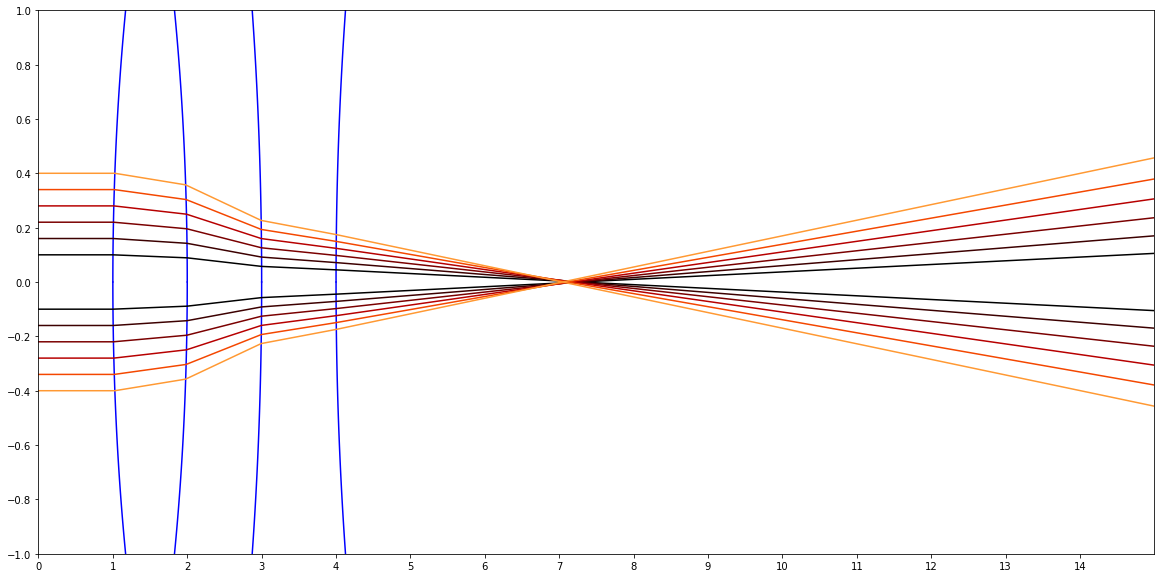

In [97]:
fig1=plt.figure(figsize=(20,10));
ax1=fig1.add_subplot(111)
ax1.plot(f,x,color='blue')
ax1.plot(f,-x,color='blue')
col = np.linspace(0, 0.8, pocet_paprsku)
for ii in range(pocet_paprsku):
    list2print=svazek['paprsek '+str(ii+1)]
    x_plot,y_plot=zip(*list2print)
    x_plot=list(x_plot)
    negx=[-x_plot for x_plot in x_plot ]
    ax1.plot(y_plot,x_plot,y_plot,negx,color=plt.cm.gist_heat(col[ii]))
ax1.set(xlim=(0,15),ylim=(-1,1),xticks=np.arange(0, 15, 1.0),yticks=np.arange(-1, 1.2, 0.2))